In [13]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import glob
from tqdm import tqdm
from sklearn.utils import shuffle
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


def get_N_matrix(topic, verbose=True, drop_subsumed=True):
    verboseprint = print
    MEDIA = ['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']
    cv = CountVectorizer(max_df=0.9, min_df=10, max_features=10000, ngram_range=(1,3))

    df = pd.read_csv('../data/sorted/'+topic+'.csv', index_col=0)
    cv.fit(df['preprocessed'])

    df['preprocessed'] = df['preprocessed'] + ' '
    df = df[['medium', 'preprocessed', 'dominant topic']]
    df_grouped = df.groupby(['medium', 'dominant topic']).sum()

    df = pd.DataFrame(index=MEDIA, columns=['preprocessed'])
    for medium in MEDIA:
        df.loc[medium] = df_grouped.loc[medium].loc[topic]['preprocessed']

    
    N_matrix = cv.transform(df['preprocessed'].values)

    N_df = pd.DataFrame(data=N_matrix.toarray().transpose(),
                        columns=df.index,
                        index=cv.get_feature_names_out())

    if drop_subsumed:
        N_df = N_df.reset_index().rename(columns={'index':'phrase'})
        N_df['n_gram'] = N_df['phrase'].apply(str.split).apply(len)
        N_df['count'] = N_df[['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']].sum(axis=1)

        monograms = N_df[N_df['n_gram'] == 1]
        bigrams = N_df[N_df['n_gram'] == 2]
        trigrams = N_df[N_df['n_gram'] == 3]

        verboseprint('extracting bigrams and trigrams...')
        bigram_words = list(set([word for bigram_sublist in bigrams['phrase'].apply(str.split).tolist() for word in bigram_sublist]))
        trigram_words = list(set([word for trigram_sublist in trigrams['phrase'].apply(str.split).tolist() for word in trigram_sublist]))

        verboseprint('extracting subsumed n-grams')
        monograms_in_bigrams = monograms[monograms['phrase'].isin(bigram_words)]
        monograms_in_trigrams = monograms[monograms['phrase'].isin(trigram_words)]
        bigrams_in_trigrams_words = list(set([bigram_word for bigram_word in bigram_words if bigram_word in trigram_words]))
        bigrams_in_trigrams_mask = bigrams['phrase'].apply(lambda bigram: True if bigram.split()[0] in bigrams_in_trigrams_words or bigram.split()[1] in bigrams_in_trigrams_words else False)
        bigrams_in_trigrams = bigrams[bigrams_in_trigrams_mask]

        threshold = 0.7
        verboseprint(f'filtering n-grams which are subsumed more than {int(100*threshold)}% of the time...')
        monograms_in_bigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_bigrams.iterrows() for _, bigram in bigrams.iterrows() if monogram['phrase'] in bigram['phrase'].split() and bigram['count'] > threshold*monogram['count']]))
        monograms_in_trigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if monogram['phrase'] in trigram['phrase'].split() and trigram['count'] > threshold*monogram['count']]))
        bigrams_in_trigrams_above_threshold = list(set([bigram['phrase'] for _, bigram in bigrams_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if (bigram['phrase'] in " ".join(trigram['phrase'].split()[:2]) or bigram['phrase'] in " ".join(trigram['phrase'].split()[-2:])) and trigram['count'] > threshold*bigram['count']]))
        n_grams_above_threshold = list(set(np.append(np.append(monograms_in_bigrams_above_threshold, monograms_in_trigrams_above_threshold), bigrams_in_trigrams_above_threshold)))

        N_df.drop(N_df[N_df['phrase'].isin(n_grams_above_threshold)].index, inplace = True)
        N_df.set_index('phrase', inplace=True)
        N_df.drop(columns=['n_gram', 'count'], inplace=True)

    return N_df

In [39]:
topic = 'None'
N_df = get_N_matrix(topic=topic)

KeyError: 'preprocessed'

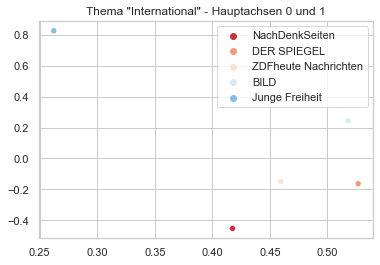

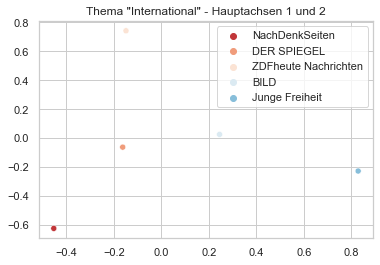

In [38]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

r=3

scaler = StandardScaler()
model = TruncatedSVD(n_components=r)

N_scaled = scaler.fit_transform(N_df.values)
N_df_trunc = model.fit_transform(N_scaled)

sns.set(palette='RdBu', style='whitegrid')
sns.scatterplot(model.components_[0], model.components_[1], hue=['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']).set(title=f'Thema "{topic}" - Hauptachsen 0 und 1')
plt.figure()
sns.scatterplot(model.components_[1], model.components_[2], hue=['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']).set(title=f'Thema "{topic}" - Hauptachsen 1 und 2')
plt.show()

In [32]:
df = pd.read_csv('../data/labeled/BILD_labeled.csv', index_col=0)

In [33]:
df['dominant topic'].value_counts()

None                  3618
Justiz                2070
Live                  1394
Bildung               1230
Familie               1169
COVID-19 Maßnahmen     889
Wirtschaft             741
Fußball                474
Flüchtlingskrise       467
Interview              467
Innenpolitik           443
Ukrainekonflikt        375
USA                    300
Befragung              283
Abspann                263
Impfung                188
Ampelregierung         146
Krieg                  130
Wahlen                 120
Gender                  98
Schule                  77
Angela Merkel           54
Soziale Medien          52
CDU-CSU                 41
International           22
Lokal                    2
Name: dominant topic, dtype: int64

In [29]:
df.head()

,Unnamed: 0,medium,title,id,duration,transcript,preprocessed,Bildung,Ampelregierung,Innenpolitik,...,Ukrainekonflikt,Wirtschaft,Schule,COVID-19 Maßnahmen,Interview,USA,Flüchtlingskrise,International,CDU-CSU,dominant topic
0,0,NachDenkSeiten,„Wir leben in einer Demokratie“ | Albrecht Mül...,8tAr69ZggHU,6:58,[Musik] der konzentration im medienbereich nac...,konzentration medienbereich kritisch website k...,0.085818,0.079274,0.098796,...,0.056949,0.015870,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,NaN
1,1,NachDenkSeiten,Privilegien vs. Verantwortung – der Fall Anne ...,z8-wqXP0Dm4,5:44,alle spiegel übernahm trotz krankheit tage nac...,all übernehmen trotzen krankheit flutkatastrop...,0.019344,0.075947,0.317801,...,0.000301,0.000301,0.038600,0.140044,0.000301,0.000301,0.000301,0.024176,0.000301,NaN
2,2,NachDenkSeiten,Ja: Ihr habt bei Corona #mitgemacht | Tobias R...,6_0pxMFweT4,10:37,internet pranger ein sehr fragwürdiges berline...,internet pranger fragwürdig berliner zeitung f...,0.000198,0.000198,0.137087,...,0.007043,0.000198,0.000198,0.146592,0.000198,0.000198,0.000198,0.000198,0.000198,NaN
3,3,NachDenkSeiten,"Innenminister freut sich, dass Rheinland-Pfalz...",3noZPkA0cUQ,7:33,[Musik] man über das drehkreuz rammstein aber ...,drehkreuz rammstein weiterführend verlinkungen...,0.000268,0.119031,0.092757,...,0.059124,0.116068,0.014614,0.000268,0.000268,0.075700,0.000268,0.000268,0.000268,NaN
4,4,NachDenkSeiten,Ukrainekrieg: Deutsche Medienlandschaft endgül...,G9AUcm3DTLs,12:54,die umfassende und mutmaßlich hemmungslose gew...,umfassend mutmaßlich hemmungslose gewalt lose ...,0.000145,0.007328,0.105508,...,0.280004,0.024633,0.011999,0.062380,0.000145,0.000145,0.000145,0.000145,0.000145,NaN
